In [1]:
from src.tree_sitter_AST_utils import Tree_Sitter_ENFA, sub_str_from_coords, Node_Processor, \
                                        Code_Parser, StringTSNode, get_grammar_vocab, regex_to_member, \
                                        NodeBuilder, PartialNode, sub_str_from_coords, PartialTree
from src.dataset_loaders import CoNaLa_RawDataLoader, Django_RawDataLoader
from src.DataProcessors import Parse_Tree_Translation_DataProcessor
from src.translation_transformer import Translation_Transformer
from src.Experiments import TranslationExperiment
import json
import networkx as nx
import torch
from IPython.display import Image, display
import matplotlib.pyplot as plt
import autopep8
from collections.abc import Iterable
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# Parsing code -> tree -> sequence -> tree -> code

In [2]:
code_str = """
def baz():
    if foo:
        l = bar.t
        print(6.77, "qux qux")
    else:
        oliv.g
"""
grammar_path = "src/tree-sitter/tree-sitter-python/src/grammar.json"
with open(grammar_path, "r") as grammar_file:
    python_grammar = json.load(grammar_file)
    
extra_externals = {"_string_start":{
                      "type": "PATTERN",
                      "value": '"'
                    },
                   "_string_content":{
                      "type": "PATTERN",
                      "value": "[A-Za-z0-9 _,.()\/{}!$@'*]*"
                    },
                   "_string_end":{
                      "type": "PATTERN",
                      "value": '"'
                    },
                   "_newline":{
                      "type": "BLANK"
                    }
                  }
for node_type, member in extra_externals.items():
    python_grammar["rules"][node_type] = member

python_parser = Code_Parser(python_grammar, "python")
node_processor = Node_Processor()

In [3]:
sequence = python_parser.code_to_sequence(code_str)

In [4]:
sequence = ['module', 'function_definition', 'def', '<REDUCE>', 'identifier', 'baz', '<REDUCE>', 'parameters', '(', 
 '<REDUCE>', ')', '<REDUCE>', '<REDUCE>', ':', '<REDUCE>', 'block', 'if_statement', 'if', '<REDUCE>', 
 'identifier', 'foo', '<REDUCE>', ':', '<REDUCE>', 'block', 'expression_statement', 'assignment', 
 'expression_list', 'identifier', 'l', '<REDUCE>', '<REDUCE>', '=', '<REDUCE>', 'expression_list', 
 'attribute', 'identifier', 'bar', '<REDUCE>', '.', '<REDUCE>', 'identifier', 't', '<REDUCE>', '<REDUCE>', 
 '<REDUCE>', '<REDUCE>', '<REDUCE>', 'expression_statement', 'call', 'identifier', 'print', '<REDUCE>', 
 'argument_list', '(', '<REDUCE>', 'float', '6.77', '<REDUCE>', ',', '<REDUCE>', 'string', '_string_start', 
 '"', '<REDUCE>', '_string_content', 'qux ', "hello world!", ]

In [5]:
partial_tree = python_parser.sequence_to_partial_tree(sequence)

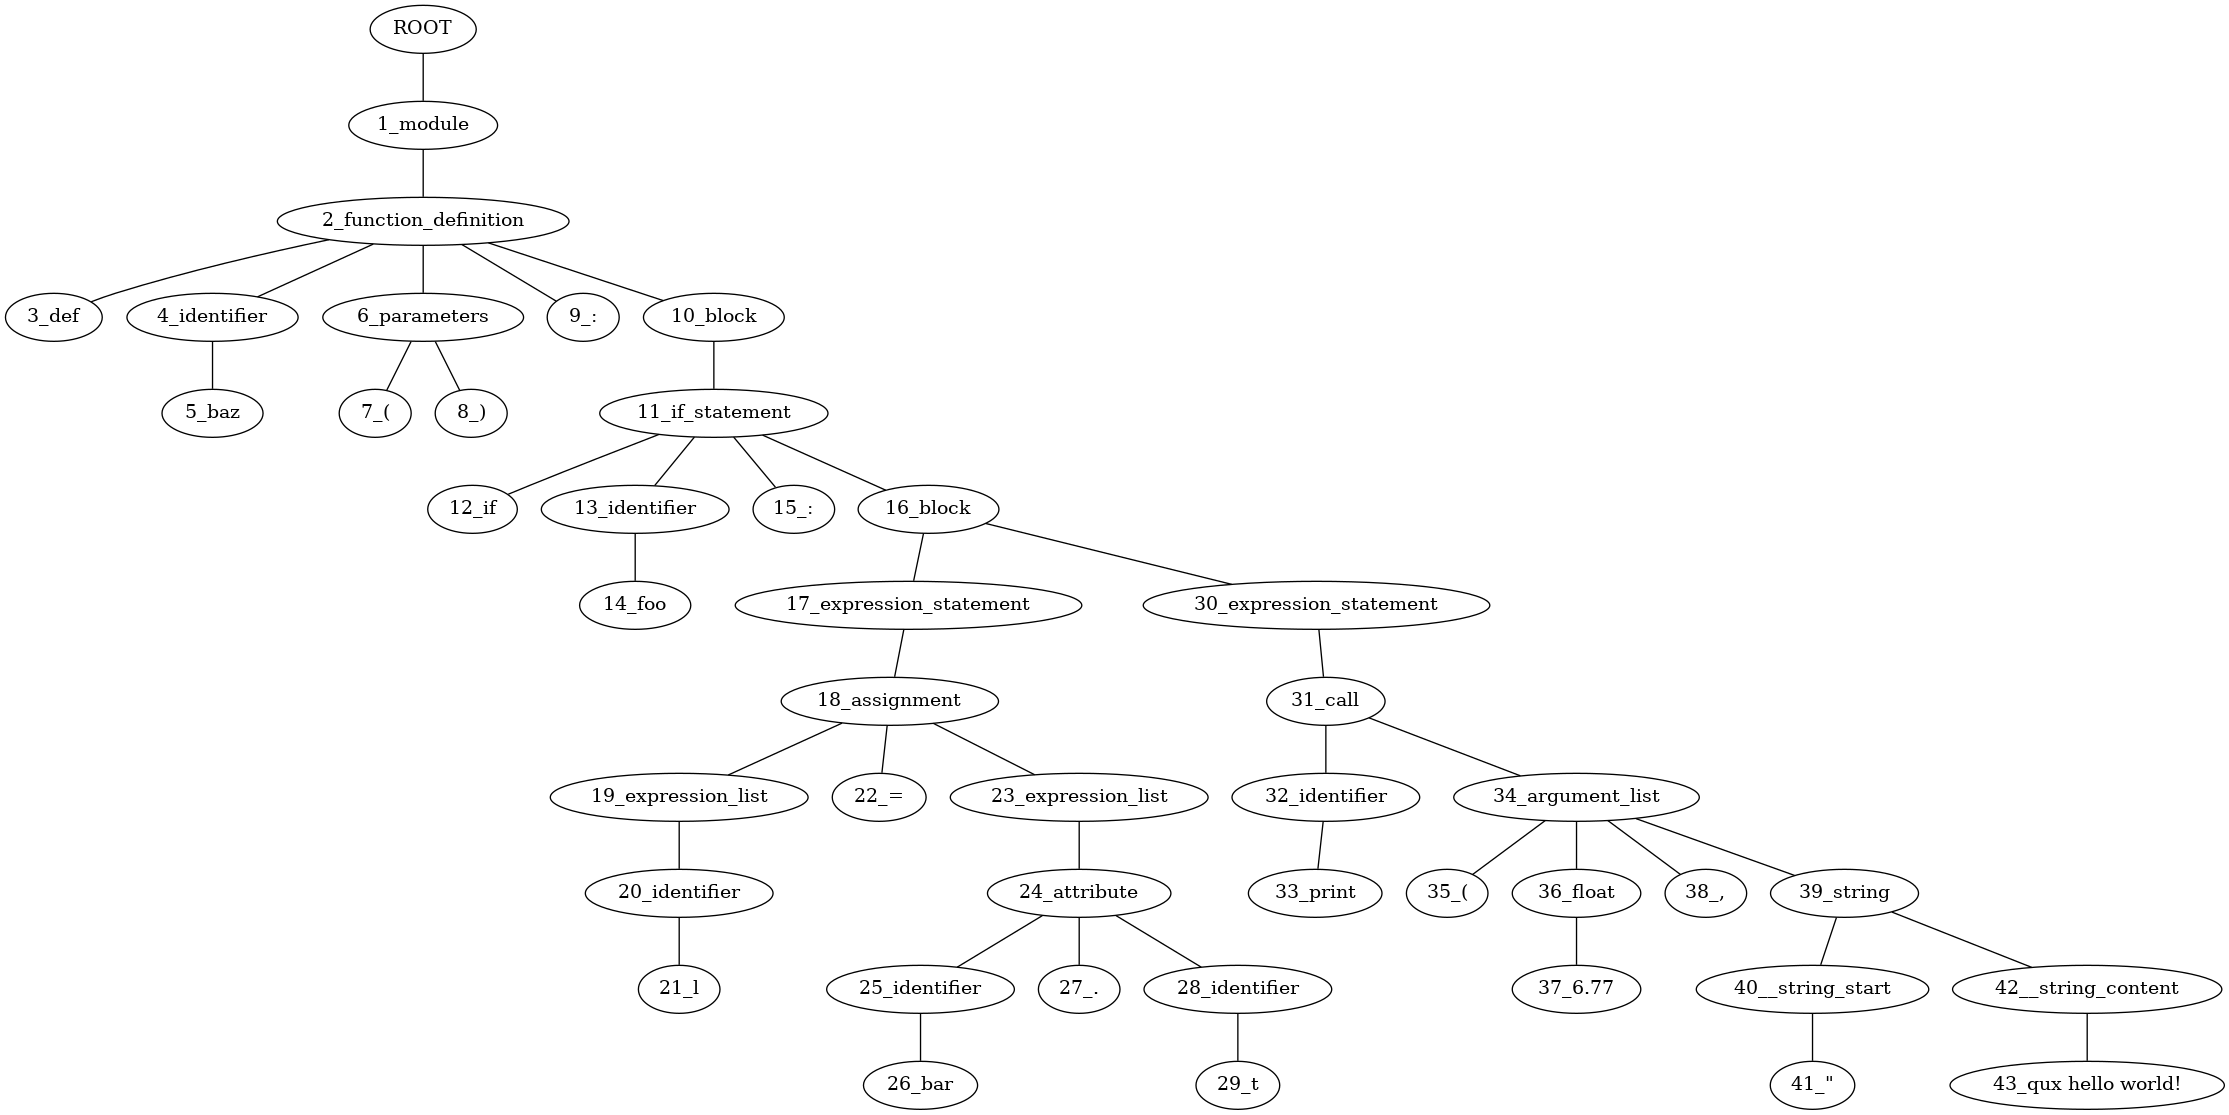

In [6]:
node_processor.plot(partial_tree.root)

In [7]:
print(node_processor.pretty_print(partial_tree.root))

def baz():
    if foo:
        l = bar .t
        print(6.77, "qux hello world!



# Partial trees and expansions

In [8]:
partial_tree = python_parser.sequence_to_partial_tree(sequence[:10])

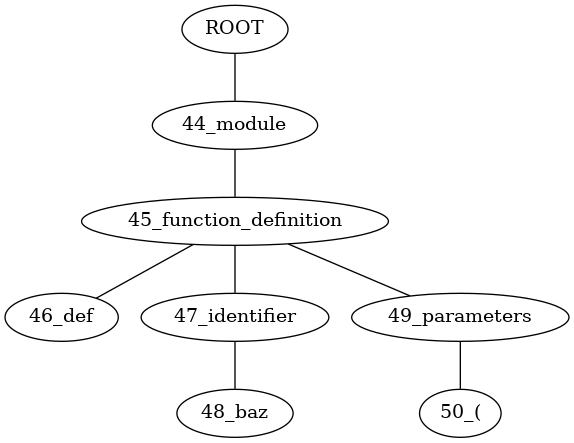

In [9]:
node_processor.plot(partial_tree.root)

In [10]:
print(node_processor.pretty_print(partial_tree.root))

def baz(



In [11]:
partial_tree.pointer.explicit_expansions

{')',
 '*',
 'default_parameter',
 'dictionary_splat',
 'identifier',
 'keyword_identifier',
 'list_splat',
 'tuple',
 'typed_default_parameter',
 'typed_parameter'}

In [12]:
partial_tree.pointer.is_valid_pattern_expansion(")")

True

## Adding incorrect expansions

In [13]:
partial_tree.add_action("(")

AssertionError: ( is not currently a valid expansion for parameters. possible explicit ones: {'keyword_identifier', 'tuple', 'identifier', 'typed_default_parameter', 'typed_parameter', 'dictionary_splat', 'default_parameter', '*', ')', 'list_splat'}

# Grammar vocabulary

In [14]:
vocab, grammar_patterns = get_grammar_vocab(python_grammar)

In [15]:
list(vocab)[:10]

['while_statement',
 '(',
 '>',
 '**=',
 '\\',
 '_simple_statement',
 'future_import_statement',
 'is',
 'yield',
 'exec_statement']

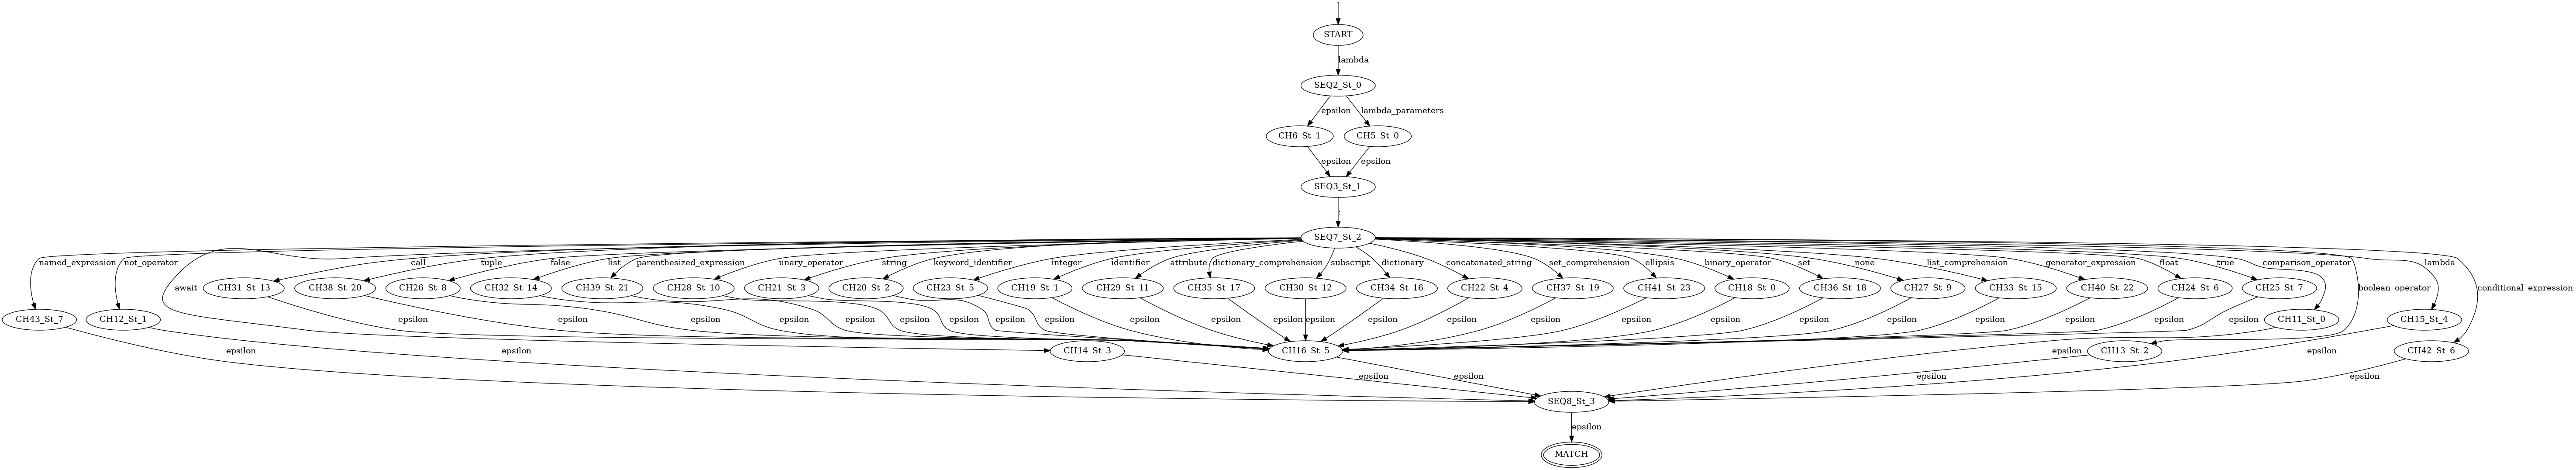

In [16]:
node_NFA = Tree_Sitter_ENFA("lambda", python_grammar)
node_NFA.plot_dot()

# Parsing the CoNaLa dataset

In [3]:
CoNaLa_raw_data_loader = CoNaLa_RawDataLoader()

In [4]:
train_pairs = CoNaLa_raw_data_loader.english_to_code_for_translation("train")

In [3]:
Django_raw_data_loader = Django_RawDataLoader()

In [4]:
train_pairs = Django_raw_data_loader.english_to_code_for_translation("train")

In [7]:
from tokenizers import ByteLevelBPETokenizer
tokenizer = ByteLevelBPETokenizer("/nfs/phd_by_carlos/notebooks/datasets/code_search_net/code_bpe_hugging_32k-vocab.json",
                                          "/nfs/phd_by_carlos/notebooks/datasets/code_search_net/code_bpe_hugging_32k-merges.txt")

In [5]:
%%capture
parse_tree_processor = Parse_Tree_Translation_DataProcessor(train_pairs)

In [6]:
print(len(train_pairs), len(parse_tree_processor.task_data))

16077 8443


In [7]:
parse_tree_processor.task_data[:10]

[('from django.db.migrations.autodetector import MigrationAutodetector into default name space.',
  'from django . db . migrations . autodetector import MigrationAutodetector'),
 ('from django.db.migrations.executor import MigrationExecutor into default name space.',
  'from django . db . migrations . executor import MigrationExecutor'),
 ('from django.db import connections and DEFAULT_DB_ALIAS into default name space.',
  'from django . db import connections , DEFAULT_DB_ALIAS'),
 ('from django.utils.translation import templatize into default namespace.',
  'from django . utils . translation import templatize'),
 ('from django.test.utils import get_runner into default name space.',
  'from django . test . utils import get_runner'),
 ('from django.utils import six into default name space.',
  'from django . utils import six'),
 ('from django.core.management.base import CommandError into default name space.',
  'from django . core . management . base import CommandError'),
 ('from djang

In [25]:
ids = parse_tree_processor.encode_code("print('foo bar')")

In [26]:
parse_tree_processor.decode_code(ids)

Tree generation terminated


('print("foo bar")\n',
 <src.tree_sitter_AST_utils.PartialTree at 0x7f9694d767f0>)

In [7]:
train_dataloader = parse_tree_processor.to_dataloader(32, num_workers=0)

In [9]:
for i_batch, sample_batched in enumerate(train_dataloader):
#     print(sample_batched["tgt"].T==32003)
    break

(array([2.944e+03, 2.622e+03, 1.677e+03, 8.780e+02, 1.710e+02, 6.400e+01,
        3.500e+01, 1.300e+01, 7.000e+00, 9.000e+00, 5.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  4.        ,  12.66666667,  21.33333333,  30.        ,
         38.66666667,  47.33333333,  56.        ,  64.66666667,
         73.33333333,  82.        ,  90.66666667,  99.33333333,
        108.        , 116.66666667, 125.33333333, 134.        ,
        142.66666667, 151.33333333, 160.        , 168.66666667,
        177.33333333, 186.        , 194.66666667, 203.33333333,
        212.        , 220.66666667, 229.33333333, 238.        ,
        246.66666667, 255.33333333, 264.        ]),
 <a list of 30 Patch objects>)

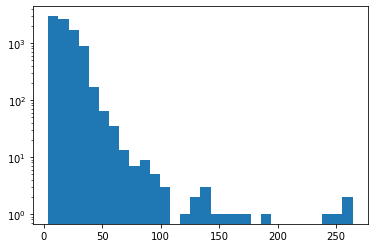

In [9]:
plt.hist([len(parse_tree_processor[i]["src"]) for i in range(len(parse_tree_processor))], log=True, bins=30)

## Seting up the model

In [8]:
full_vocab_size = parse_tree_processor.tokenizer.get_vocab_size()
full_vocab_size

32113

In [9]:
translator = Translation_Transformer(parse_tree_processor,
                                     full_vocab_size, 
                                     embed_dim=256, 
                                     att_heads=4, 
                                     layers=4, 
                                     dim_feedforward=1024, 
                                     max_seq_length=550,
                                     use_copy=False)

In [10]:
%%capture
translator.model.to("cuda")

In [11]:
translator.model.device

device(type='cuda', index=0)

In [12]:
translator.load("./translator_Django.pytorch")

In [14]:
translator.train(100, train_dataloader)

Keyboard Interrupt!


In [15]:
outputs = translator.raw_batch_predict(["x is a list","return x"], max_len=100)
code, tree = outputs[0]
outputs

[('x = x\n', <src.tree_sitter_AST_utils.PartialTree at 0x7f073343da90>),
 ('return return\n',
  <src.tree_sitter_AST_utils.PartialTree at 0x7f073345d518>)]

In [29]:
%lprun -u 0.001 -f parse_tree_processor.python_parser.is_valid_sequence translator.raw_batch_predict(["x isffffffhjhjhjhj jhj jhj jhjffffff a list","retufrn x"], max_len=100)

Timer unit: 0.001 s

Total time: 1.53977 s
File: /nfs/phd_by_carlos/notebooks/src/tree_sitter_AST_utils.py
Function: is_valid_sequence at line 329

Line #      Hits         Time  Per Hit   % Time  Line Contents
   329                                               def is_valid_sequence(self, sequence):
   330       681          0.5      0.0      0.0          first_node = sequence[0]
   331       681          0.3      0.0      0.0          if first_node != "module":
   332                                                       return False
   333       681          6.2      0.0      0.4          partial_tree = PartialTree(first_node, self.node_builder)
   334       681          0.2      0.0      0.0          try:
   335     10656          4.2      0.0      0.3              for expansion in sequence[1:]:
   336     10458       1527.6      0.1     99.2                  partial_tree.add_action(expansion)
   337       483          0.3      0.0      0.0          except Exception as e:
   338  

x = x



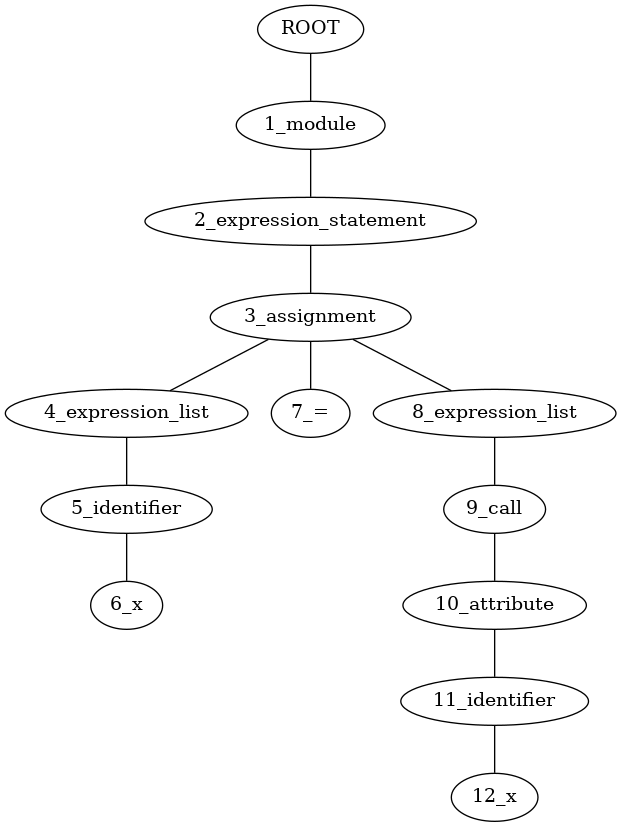

In [16]:
print(code)
node_processor.plot(tree.root)

In [31]:
%%capture
test_pairs = Django_raw_data_loader.english_to_code_for_translation("test")
test_parse_tree_processor = Parse_Tree_Translation_DataProcessor(test_pairs)
test_pairs = test_parse_tree_processor.task_data

In [32]:
test_dict = {k:v for k,v in test_pairs}

In [33]:
def orarcle_predictor(src):
    return test_dict[src]

In [34]:
def translation_batch_predictor(src_sents):
    outputs = translator.raw_batch_predict(src_sents, max_len=250)
    return [code for code, tree in outputs]

In [37]:
Django_experiment = TranslationExperiment(test_pairs[:5])

In [45]:
Django_experiment.evaluate(translation_batch_predictor, batched=1, save_dir="./", save_name="translation_eval_batch1.txt")


saving translation eval to file: ./translation_eval_batch1.txt
| EVALUATION | BLEU: 0.135 |


{'BLEU': 0.13547669353976427}

In [122]:
from src.useful_utils import chunks

In [126]:
a = [1,2,3,4,5,6,7]
b = [2,3,4,5,6,7,8]

list(chunks(list(zip(a,b)), 2))

[[(1, 2), (2, 3)], [(3, 4), (4, 5)], [(5, 6), (6, 7)], [(7, 8)]]